# Task 2: Player Segment Classification

Problem: Marketing runs generic campaigns across all players, achieving only 2-5% engagement. The company spends ฿60 million monthly on promotions, but can't identify the top 5% of players (whales) who generate 60% of revenue.

Your Task: Classify players into four behavioral segments:

- Class 0: Casual Player (relaxed play, low spending)
- Class 1: Competitive Grinder (high playtime, ranked focus)
- Class 2: Social Player (friend-focused, cosmetic spending)
- Class 3: Whale (high spending, status-driven)

Metric: F₁ Score (Macro)

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [13]:
# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())
print(test_df.head())

         id player_id  play_frequency  avg_session_duration  \
0  PLY00001   P050236        5.495437             24.837349   
1  PLY00002   P108696        9.991089             88.376322   
2  PLY00003   P113532       14.234225            101.712292   
3  PLY00004   P123930        3.373683            191.975841   
4  PLY00005   P068623       22.469353             28.042509   

   total_playtime_hours  login_streak  days_since_last_login  \
0           2740.945124          60.0              56.034052   
1                   NaN          22.0              75.036888   
2           2828.479467          66.0                    NaN   
3           1915.082950          80.0               0.127910   
4            517.921948           NaN              45.078460   

   total_spending_thb  avg_monthly_spending  spending_frequency  ...  \
0        58219.915660            434.038311           17.790970  ...   
1        28966.163953           4233.532935           28.862134  ...   
2        44478.82383

/tmp/ipykernel_12181/3560823615.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='segment', palette='viridis')


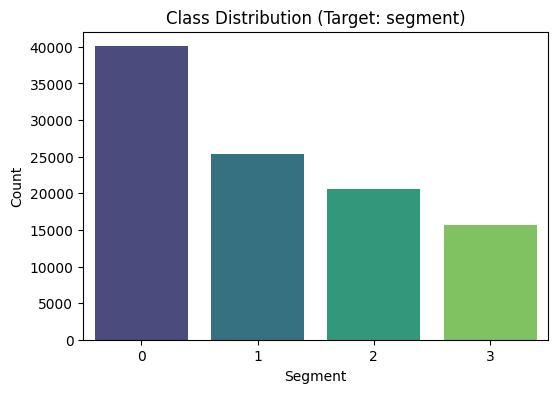

In [14]:
# EDA Findings

plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='segment', palette='viridis')
plt.title("Class Distribution (Target: segment)")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()

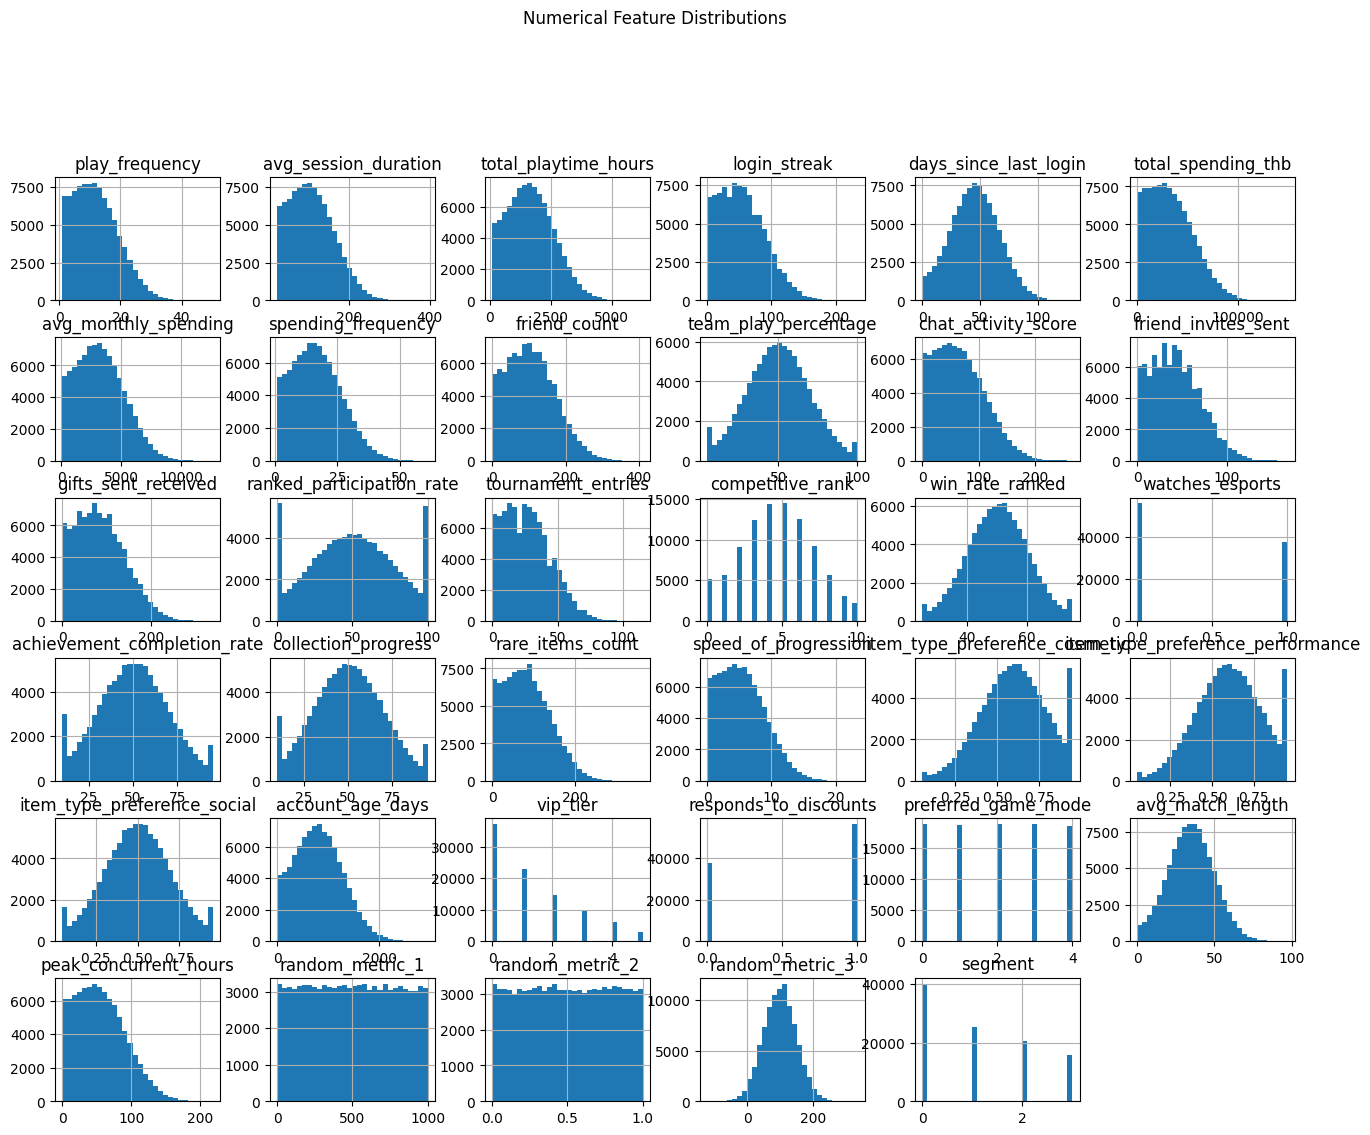

In [15]:
numeric_cols = train_df.select_dtypes(include=['number']).columns

train_df[numeric_cols].hist(figsize=(16,12), bins=30)
plt.suptitle("Numerical Feature Distributions", y=1.02)
plt.show()

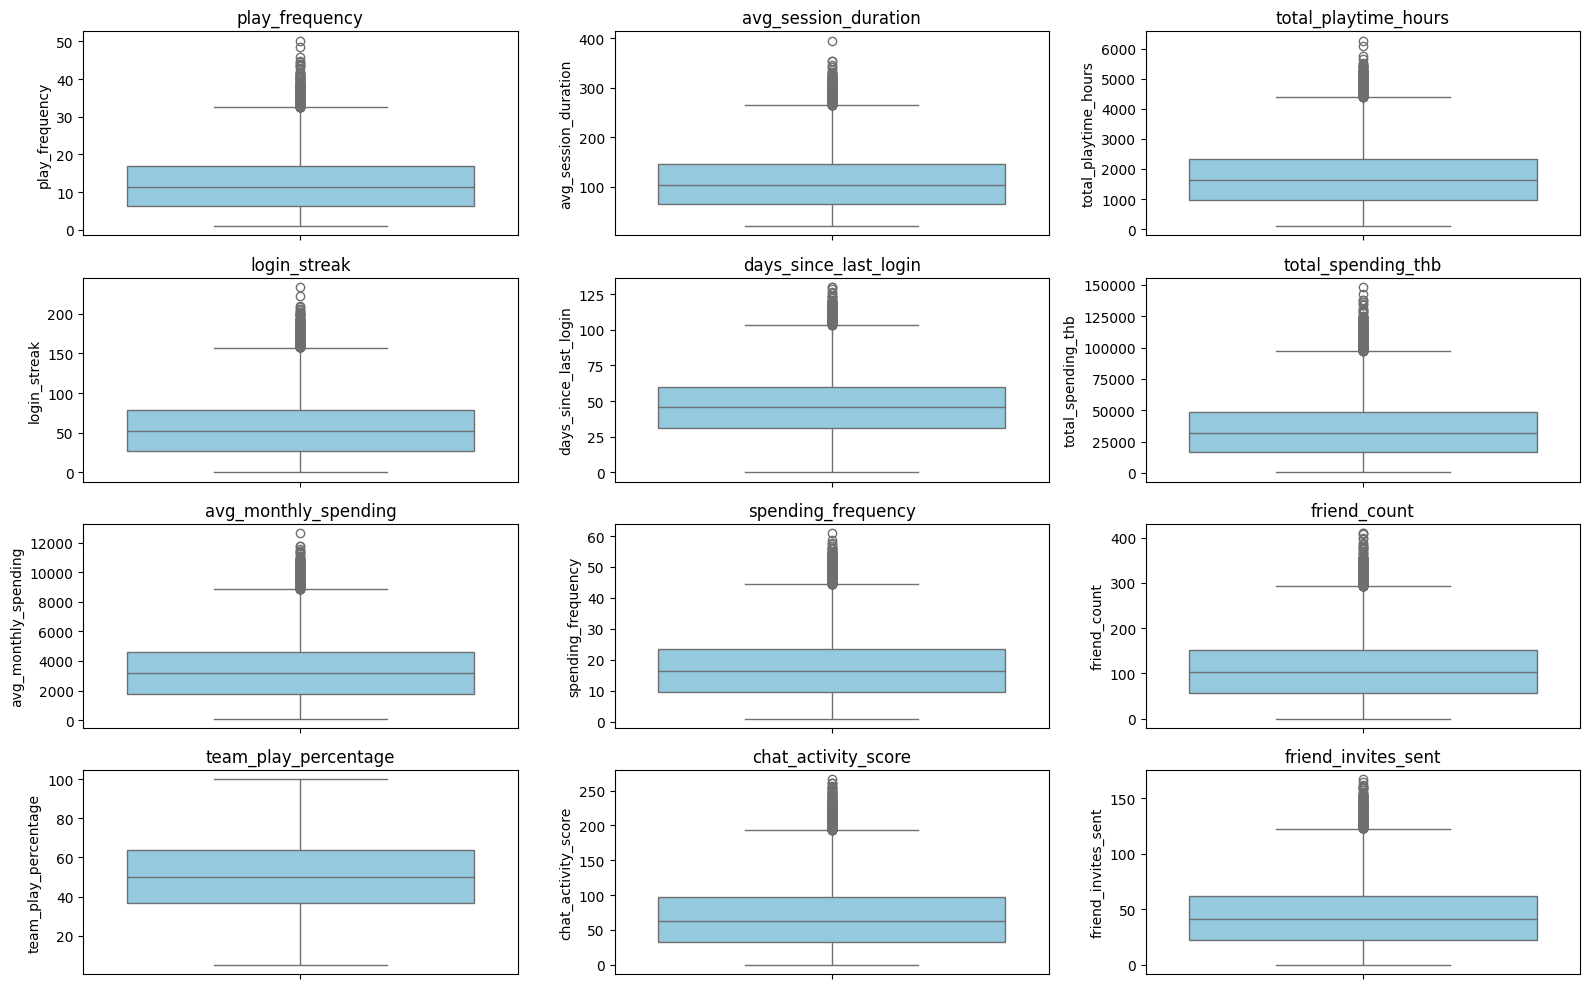

In [16]:
plt.figure(figsize=(16,10))
for i, col in enumerate(numeric_cols[:12]):  # limit to 12 to avoid huge plot
    plt.subplot(4, 3, i+1)
    sns.boxplot(data=train_df, y=col, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

In [17]:
# Data Preparation

# Separate features and target 
y_train = train_df['segment']
X_train = train_df.drop(columns=['id', 'player_id', 'segment'])

X_test  = test_df.drop(columns=['id', 'player_id'])

In [18]:
# Feature Engineering

def add_features(df):
    # Avoid division by zero
    eps = 1e-6

    # Ratios
    df["spending_per_hour"] = df["total_spending_thb"] / (df["total_playtime_hours"] + eps)
    df["spending_per_session"] = df["total_spending_thb"] / (df["play_frequency"] + eps)
    df["sessions_per_day"] = df["play_frequency"] / (df["login_streak"] + eps)
    df["gift_per_friend"] = df["gifts_sent_received"] / (df["friend_count"] + 1)
    df["chat_per_session"] = df["chat_activity_score"] / (df["play_frequency"] + eps)
    df["teamplay_per_session"] = df["team_play_percentage"] * df["play_frequency"]

    # Interaction Features
    df["spend_x_frequency"] = df["total_spending_thb"] * df["spending_frequency"]
    df["activity_intensity"] = df["play_frequency"] * df["avg_session_duration"]
    df["engagement_score"] = (
        df["login_streak"] +
        df["chat_activity_score"] +
        df["team_play_percentage"] * 10
    )

    # Log transforms (handle zero safely)
    df["log_total_spending"] = np.log1p(df["total_spending_thb"])
    df["log_playtime"] = np.log1p(df["total_playtime_hours"])

    # Player tiers
    df["spending_bin"] = pd.qcut(df["total_spending_thb"], q=4, labels=False, duplicates='drop')
    df["playtime_bin"] = pd.qcut(df["total_playtime_hours"], q=4, labels=False, duplicates='drop')

    # Missing indicators
    for col in df.columns:
        df[col + "_is_missing"] = df[col].isna().astype(int)

    return df


X_train_fe = add_features(X_train.copy())
X_test_fe  = add_features(X_test.copy())

In [19]:
# Data Preprocessing

categorical_features = X_train_fe.select_dtypes(include=['object']).columns
numerical_features = X_train_fe.select_dtypes(include=['number']).columns

# Create pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [20]:
# Create Pipeline

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cat = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    verbose=0,
    random_state=42,
    thread_count=-1
)

# Stacking all models together
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgb', lgbm),
        ('cat', cat)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)


model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # handle class imbalance
    ('classifier', stack_model)
])

In [21]:
# Train/Test Split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_fe, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [22]:
# Model Training

model.fit(X_tr, y_tr)

y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred, average='macro')
print("F1 Macro on validation:", f1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.182962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38391
[LightGBM] [Info] Number of data points in the train set: 128204, number of used features: 154
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38179
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from 

/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid f

F1 Macro on validation: 0.7474308083927746


In [23]:
# Cross Validation

# Use StratifiedKFold cross-validation to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Cross-validation on full train

cv_scores = cross_val_score(model, X_train_fe, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print("CV F1 Macro Scores:", cv_scores)
print("Mean CV F1 Macro:", np.mean(cv_scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38397
[LightGBM] [Info] Number of data points in the train set: 128204, number of used features: 154
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.707396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38401
[LightGBM] [Info] Number of data points in the train set: 128204, number of used features: 154
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start trai

/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38397
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386324
[LightGBM] [Info] Start training from score -1.386285


/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38365
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386324


/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38180
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386324
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285


/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.380502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38140
[LightGBM] [Info] Number of data points in the train set: 102564, number of used features: 154
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mirailisc/cpe342-karena/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.948762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38402
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386324
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.149265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38378
[LightGBM] [Info] Number of data points in the train set: 102563, number of used features: 154
[LightGBM] [Info] Start training from score -1.386285
[LightGBM] [Info] 

In [ ]:
# Predict and Evaluate

predictions =  model.predict(X_test_fe)
submission_df = pd.DataFrame({'id': test_df['id'], 'task2': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")